<img align="left" src="https://github.com/GarethSequeira/News-Classification/blob/main/NewsClassification/Images/NewsRect.png?raw=true" width="100%">  

<br><br>  
  
# News Classification
### Classify News as Real or Fake News

#### Import Libraries

In [1]:
import re
import string
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from wordcloud import WordCloud, STOPWORDS

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

#### Load Datasets

In [2]:
real_news_df = pd.read_csv('RealNews.csv')
fake_news_df = pd.read_csv('FakeNews.csv')

#### Create Real News Dataframe

In [3]:
real_news_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


#### Create Fake News Dataframe

In [4]:
fake_news_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


## Data Visualization
On Original Dataframes
#### Use Wordcloud to Display Reccuring Stopwords

In [5]:
stopwords = set(STOPWORDS)

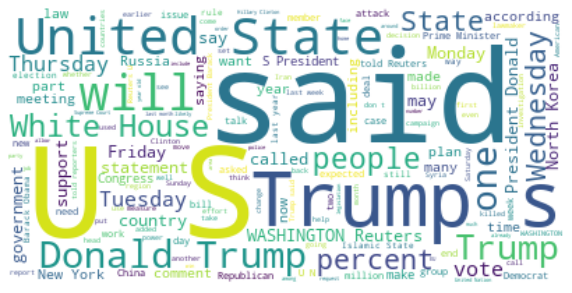

In [6]:
# Real News Word Cloud
real_news_wc = WordCloud(background_color='white', 
                         max_words=150, stopwords=stopwords).generate(''.join(real_news_df['text']))


f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.imshow(real_news_wc, interpolation='bilinear')
ax.axis('off')
ax.set_label('Real News')

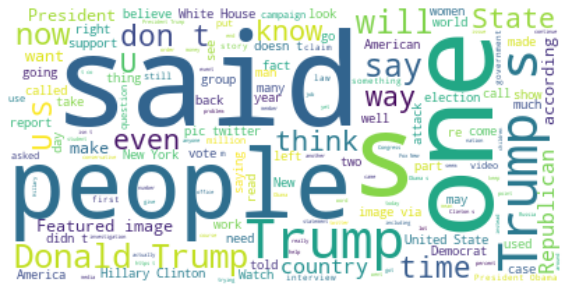

In [7]:
# Fake News Oord Cloud
fake_news_wc = WordCloud(background_color='white', 
                         max_words=150, stopwords=stopwords).generate(''.join(fake_news_df['text']))

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.imshow(fake_news_wc, interpolation='bilinear')
ax.axis('off')
ax.set_label('Fake News')

## Data Pre-Processing

### Helper Functions

In [8]:
def convert_from_list_to_text(_list):
    text = ' '.join(_list)
    return text


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, Without Normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real label')
    plt.xlabel('Predicted label')

### Unique Word Analysis

In [9]:
def unique(text):
    text = text.split()
    return list(set(text))

In [10]:
real_news_df['text']  = real_news_df['text'].apply(lambda x: unique(x))
fake_news_df['text']  = fake_news_df['text'].apply(lambda x: unique(x))

real_news_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...","[requested, rationale, votes, Paul, give, Medi...",politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,"[wait, independent, requirements, rights., app...",politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,"[weeks, Face, in, would, sign, down,, time.”, ...",politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,"[April, in, ties, limited”, would, speech, now...",politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,"[liabilities., April, allocates, independent, ...",politicsNews,"December 29, 2017"


<br>

## Data Cleaing
#### Punctuation Removal

In [11]:
# Removing Punctuation from a Word if it exists

def rm_punc_from_word(word):
    clean_word = ''                # word without punctuation
    for alpha in word:
        # checking if alphabet is punctuation or not
        if alpha in string.punctuation:
            continue
        clean_word += alpha
        
    return clean_word



# Remove any Punctuation and Clean Words having Punctuation

def clean_punc(words_list):
    for idx, word in enumerate(words_list):
        if word in string.punctuation:
            words_list.remove(word)
        else:
            words_list[idx] = rm_punc_from_word(word)
            words_list[idx] = re.sub('[0-9]+', '', words_list[idx])
            
    return words_list

In [12]:
real_news_df['text']  = real_news_df['text'].apply(lambda x: clean_punc(x))
fake_news_df['text']  = fake_news_df['text'].apply(lambda x: clean_punc(x))

real_news_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...","[requested, rationale, votes, Paul, give, Medi...",politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,"[wait, independent, requirements, rights, appl...",politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,"[weeks, Face, in, would, sign, down, time”, qu...",politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,"[April, in, ties, limited”, would, speech, now...",politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,"[liabilities, April, allocates, independent, w...",politicsNews,"December 29, 2017"


#### Numeric Value Removal

In [13]:
def rm_num(words_list):
    text = ' '.join(words_list)
    text = ''.join([i for i in text if not i.isdigit()])
    return text.split()

In [14]:
real_news_df['text']  = real_news_df['text'].apply(lambda x: rm_num(x))
fake_news_df['text']  = fake_news_df['text'].apply(lambda x: rm_num(x))

real_news_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...","[requested, rationale, votes, Paul, give, Medi...",politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,"[wait, independent, requirements, rights, appl...",politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,"[weeks, Face, in, would, sign, down, time”, qu...",politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,"[April, in, ties, limited”, would, speech, now...",politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,"[liabilities, April, allocates, independent, w...",politicsNews,"December 29, 2017"


#### Tokenization

In [15]:
def tokenization(words_list):
    tmp = words_list.copy()
    words_list = []
    
    for idx, word in enumerate(tmp):
        for split_word in re.split('\W+', word):
            words_list.append(split_word)

    words_list = ' '.join(words_list).split()  # removing any white spaces
    return words_list

In [16]:
real_news_df['text']  = real_news_df['text'].apply(lambda x: tokenization(x))
fake_news_df['text']  = fake_news_df['text'].apply(lambda x: tokenization(x))

real_news_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...","[requested, rationale, votes, Paul, give, Medi...",politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,"[wait, independent, requirements, rights, appl...",politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,"[weeks, Face, in, would, sign, down, time, que...",politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,"[April, in, ties, limited, would, speech, now,...",politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,"[liabilities, April, allocates, independent, w...",politicsNews,"December 29, 2017"


#### URL Removal

In [17]:
def remove_URL(words_list):
    url = re.compile(r'https?://\S+|www\.\S+')
    for idx, word in enumerate(words_list):
        words_list[idx] = url.sub(r'',word)
    return words_list

In [18]:
real_news_df['text']  = real_news_df['text'].apply(lambda x: remove_URL(x))
fake_news_df['text']  = fake_news_df['text'].apply(lambda x: remove_URL(x))

real_news_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...","[requested, rationale, votes, Paul, give, Medi...",politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,"[wait, independent, requirements, rights, appl...",politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,"[weeks, Face, in, would, sign, down, time, que...",politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,"[April, in, ties, limited, would, speech, now,...",politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,"[liabilities, April, allocates, independent, w...",politicsNews,"December 29, 2017"


#### HTML Tag Removal

In [19]:
def remove_HTML(words_list):
    html = re.compile(r'<.*?>')
    for idx, word in enumerate(words_list):
        words_list[idx] = html.sub(r'',word)
    return words_list

In [20]:
real_news_df['text']  = real_news_df['text'].apply(lambda x: remove_HTML(x))
fake_news_df['text']  = fake_news_df['text'].apply(lambda x: remove_HTML(x))

real_news_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...","[requested, rationale, votes, Paul, give, Medi...",politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,"[wait, independent, requirements, rights, appl...",politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,"[weeks, Face, in, would, sign, down, time, que...",politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,"[April, in, ties, limited, would, speech, now,...",politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,"[liabilities, April, allocates, independent, w...",politicsNews,"December 29, 2017"


#### Emoticon Removal

In [21]:
def remove_emoji(words_list):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # Emoticons
                           u"\U0001F300-\U0001F5FF"  # Symbols and Pictures
                           u"\U0001F680-\U0001F6FF"  # Transport and Map Symbols
                           u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    for idx, word in enumerate(words_list):
        words_list[idx] = emoji_pattern.sub(r'',word)
    return words_list

In [22]:
real_news_df['text']  = real_news_df['text'].apply(lambda x: remove_emoji(x))
fake_news_df['text']  = fake_news_df['text'].apply(lambda x: remove_emoji(x))

real_news_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...","[requested, rationale, votes, Paul, give, Medi...",politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,"[wait, independent, requirements, rights, appl...",politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,"[weeks, Face, in, would, sign, down, time, que...",politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,"[April, in, ties, limited, would, speech, now,...",politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,"[liabilities, April, allocates, independent, w...",politicsNews,"December 29, 2017"


#### Stopword Removal

In [23]:
stopwords = set(nltk.corpus.stopwords.words())

def clean_stopwords(words_list):
    for word in words_list:
        if word in stopwords:
            words_list.remove(word)
    return words_list

In [24]:
real_news_df['text']  = real_news_df['text'].apply(lambda x: clean_stopwords(x))
fake_news_df['text']  = fake_news_df['text'].apply(lambda x: clean_stopwords(x))

real_news_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...","[requested, rationale, votes, Paul, give, Medi...",politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,"[wait, independent, requirements, rights, appl...",politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,"[weeks, Face, would, sign, time, question, gre...",politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,"[April, ties, limited, would, speech, comment,...",politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,"[liabilities, April, allocates, independent, w...",politicsNews,"December 29, 2017"


#### Dataset Labelling

In [25]:
real_news_df['is_fake'] = 0
fake_news_df['is_fake'] = 1

real_news_df.head()

,title,text,subject,date,is_fake
0,"As U.S. budget fight looms, Republicans flip t...","[requested, rationale, votes, Paul, give, Medi...",politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,"[wait, independent, requirements, rights, appl...",politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,"[weeks, Face, would, sign, time, question, gre...",politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,"[April, ties, limited, would, speech, comment,...",politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,"[liabilities, April, allocates, independent, w...",politicsNews,"December 29, 2017",0


#### Word to Text Conversion

In [26]:
real_news_df['text']  = real_news_df['text'].apply(lambda x: convert_from_list_to_text(x))
fake_news_df['text']  = fake_news_df['text'].apply(lambda x: convert_from_list_to_text(x))

real_news_df.head()

,title,text,subject,date,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",requested rationale votes Paul give Medicare a...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,wait independent requirements rights applicant...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,weeks Face would sign time question greatly sh...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,April ties limited would speech comment Papado...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,liabilities April allocates independent websit...,politicsNews,"December 29, 2017",0


## Data Visualization
On Cleaned Dataframes
#### Use Wordcloud to Display Reccuring Stopwords

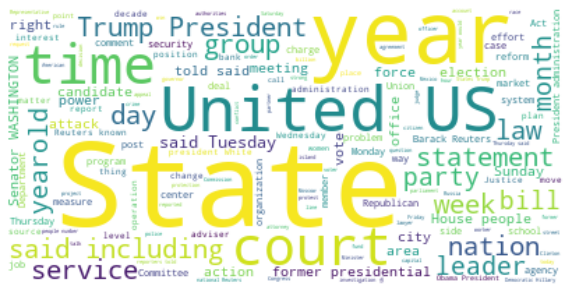

In [27]:
# Real News Word Cloud
real_news_wc = WordCloud(background_color='white', 
                         max_words=150, stopwords=stopwords).generate(''.join(real_news_df['text']))


f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.imshow(real_news_wc, interpolation='bilinear')
ax.axis('off')
ax.set_label('Real News')

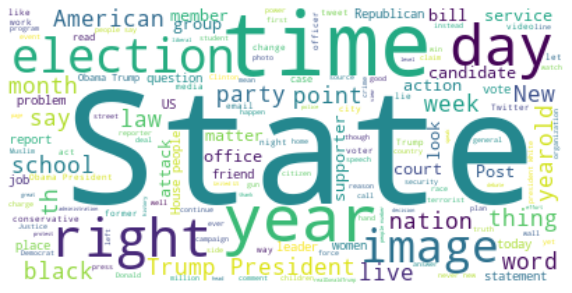

In [28]:
# Fake News Word Cloud
fake_news_wc = WordCloud(background_color='white', 
                         max_words=150, stopwords=stopwords).generate(''.join(fake_news_df['text']))

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.imshow(fake_news_wc, interpolation='bilinear')
ax.axis('off')
ax.set_label('Fake News')

#### Concatenating Real and Fake news Dataframes and Shuffling them

In [29]:
df = pd.concat([real_news_df, fake_news_df], axis='index')
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,title,text,subject,date,is_fake
0,Conservatives Are Going BONKERS Over the Indi...,waste word Devon accountable antiPlanned provi...,News,"January 26, 2016",1
1,At least 12 dead in bus crash on excursion to ...,passengers Martinez traveling lost tour learn ...,worldnews,"December 19, 2017",0
2,MN: SOMALI MAN RAPES COLLEGE STUDENT…Gets 90-D...,Elgamal apartment named When room consensual S...,left-news,"Jul 15, 2017",1
3,Iran says will never use its weapons against a...,Friday reaction Trump except Foreign tough mig...,politicsNews,"February 3, 2017",0
4,MUSLIM TEENS ATTACK CROWD for Being White “Non...,twice weeks ISIS living Muslim tried When almo...,politics,"Jul 27, 2017",1


<br><br>

## Model Creation

In [30]:
#Splitting Dataset into Test and Train

skf = StratifiedKFold(n_splits=10)

X = df.text
Y = df.is_fake

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=212)

### Feature Extraction

Texts are actually series of words.

In order to run machine learning algorithms we need to convert the text of text into numerical feature vectors.

We have used the bag of words model for our example.

Briefly, we segment each text into words by splitting it by space, **and count number of times each word occurs in each document and finally assign each word an integer id**. Each unique word in our dictionary will correspond to a descriptive feature.

Scikit-learn has a high level component CountVectorizer which will create feature vectors.

In [31]:
count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(X_train)

X_train_counts.shape

(40408, 200889)

#### TF

Just counting the number of words in each text has 1 Issue: it will give more weightage to longer texts than shorter texts. To avoid this, we can use frequency **(TF - Term Frequencies) i.e. #count(word) / #Total words**, in each  text.

#### TF-IDF

Finally, we have reduce the weightage of more common words like (the, is, an etc.) which occurs in all text. 

This is called as **TF-IDF i.e Term Frequency times inverse document frequency**.

**To achieve this TfidfTransformerfrom Scikit-learn is used**.

In [32]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_train_tfidf.shape

(40408, 200889)

### Cross Validation

In [33]:
score = cross_val_score(MultinomialNB(), X_train_tfidf, y_train, cv=skf)
print(f'MultinomialNB mean of cross validation score: {score.mean()}')

score = cross_val_score(LogisticRegression(), X_train_tfidf, y_train, cv=skf)
print(f'LogisticRegression mean of cross validation score: {score.mean()}')

score = cross_val_score(LinearSVC(), X_train_tfidf, y_train, cv=skf)
print(f'LinearSVC mean of cross validation score: {score.mean()}')

MultinomialNB mean of cross validation score: 0.9461740917967075
LogisticRegression mean of cross validation score: 0.9914621295091648
LinearSVC mean of cross validation score: 0.9974757620528198


### Pipeline

In [34]:
model = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),('clf', LinearSVC())])

### Model Fitting

In [35]:
model.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC())])

<br><br>  
  
## Model Evaluation
### Predictions

In [36]:
y_test_pred = model.predict(X_test)
np.mean(y_test_pred == y_test)

0.9973273942093541

### Score and Metric Assesment

In [37]:
print(f'Model Score: {model.score(X_test, y_test)}')
print(f'F1-Score: {f1_score(y_test, y_test_pred, average="weighted")}')
print(f'Precision Score: {precision_score(y_test, y_test_pred, average="weighted")}')
print(f'Recall Score: {recall_score(y_test, y_test_pred, average="weighted")}')

Model Score: 0.9973273942093541
F1-Score: 0.9973274388150107
Precision Score: 0.9973278797222751
Recall Score: 0.9973273942093541


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2160
           1       1.00      1.00      1.00      2330

    accuracy                           1.00      4490
   macro avg       1.00      1.00      1.00      4490
weighted avg       1.00      1.00      1.00      4490

Confusion Matrix, Without Normalization
[[2155    5]
 [   7 2323]]


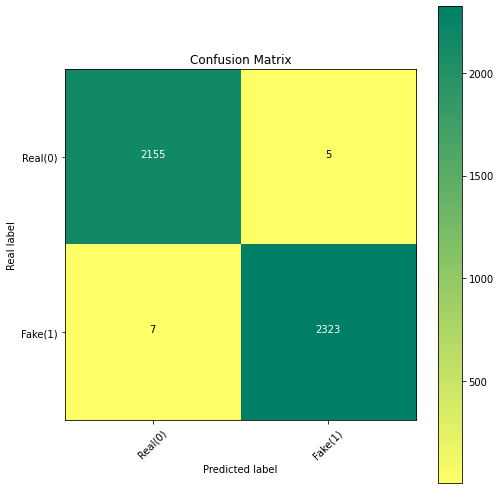

In [38]:
cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=[0,1])
np.set_printoptions(precision=2)

print(classification_report(y_test, y_test_pred))

# Plot non-normalized confusion matrix
plt.figure(figsize=(7, 7))
plot_confusion_matrix(cnf_matrix, classes=['Real(0)', 'Fake(1)'],
                      normalize= False,  title='Confusion Matrix', cmap=plt.cm.summer_r)